In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
import os

In [91]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [92]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [93]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [94]:
full_train_sets = torchvision.datasets.CIFAR10(root='cifar_10', train=True, download=True, transform=transform)
full_test_sets = torchvision.datasets.CIFAR10(root='cifar_10', train=False, download=True, transform=transform)

In [95]:
train_indices = list(range(10000))
test_indices = list(range(2000))
train_sets = Subset(full_train_sets, train_indices)
test_sets = Subset(full_test_sets, test_indices)


In [96]:
train_loader = DataLoader(train_sets, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_sets, batch_size = 128, shuffle= True)

In [97]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                              kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                              kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                 kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [98]:
#ResNet
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = nn.Sequential(Residual(64, 64), Residual(64, 64))
        self.layer2 = nn.Sequential(Residual(64, 128, use_1x1conv=True, strides=2), Residual(128, 128))
        self.layer3 = nn.Sequential(Residual(128, 256, use_1x1conv=True, strides=2), Residual(256, 256))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, 10)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        X = self.avgpool(X)
        X = torch.flatten(X, 1)
        X = self.dropout(X)
        return self.fc(X)

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [105]:
train_loss_records = []
test_loss_records = []

In [106]:
#train
def train_test(epochs=50):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # 计算平均训练损失
        avg_train_loss = train_loss / len(train_loader)
        train_loss_records.append(avg_train_loss)
        
        # 测试
        if (epoch + 1) % 5 == 0:
            model.eval()
            test_loss = 0.0
            correct = total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    test_loss += criterion(outputs, labels).item()
                    predicted = outputs.argmax(1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_loss_records.extend([avg_test_loss] * 5)  # 补齐长度
            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.3f}, '
                  f'Test Loss: {avg_test_loss:.3f}, Accuracy: {100 * correct/total:.2f}%')

In [107]:
train_test()

Epoch 5, Train Loss: 1.143, Test Loss: 1.211, Accuracy: 56.05%
Epoch 10, Train Loss: 0.854, Test Loss: 0.847, Accuracy: 69.60%
Epoch 15, Train Loss: 0.623, Test Loss: 0.860, Accuracy: 70.05%
Epoch 20, Train Loss: 0.466, Test Loss: 0.799, Accuracy: 72.65%
Epoch 25, Train Loss: 0.370, Test Loss: 0.698, Accuracy: 76.80%
Epoch 30, Train Loss: 0.264, Test Loss: 0.746, Accuracy: 78.45%
Epoch 35, Train Loss: 0.164, Test Loss: 0.846, Accuracy: 76.85%
Epoch 40, Train Loss: 0.211, Test Loss: 0.718, Accuracy: 78.60%
Epoch 45, Train Loss: 0.104, Test Loss: 0.717, Accuracy: 81.20%
Epoch 50, Train Loss: 0.098, Test Loss: 0.691, Accuracy: 82.30%


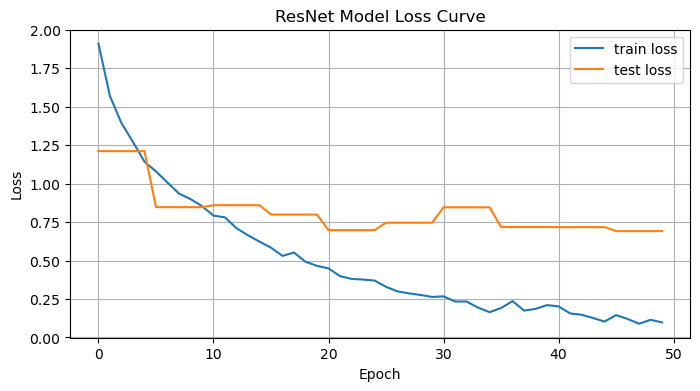

In [108]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss_records, label="train loss")
plt.plot(test_loss_records, label="test loss")
plt.title("ResNet Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()